In [49]:
import sys
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

Python version
3.7.1 (default, Dec 14 2018, 13:28:58) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Version info.
sys.version_info(major=3, minor=7, micro=1, releaselevel='final', serial=0)


In [50]:
import torch
print(torch.__version__)

# 1.4.0

1.4.0


<div class="alert alert-info">

### Abstract Text Summarisation using encoder-decoder with LSTM and attention
    
    
Corpus: 
<ul>
    <li> Annotated Enron Subject Line Corpus (AESLC)
    <li> download link: https://github.com/ryanzhumich/AESLC
    <li> paper: https://www.aclweb.org/anthology/P19-1043.pdf
</ul>    
    
The task of that corpus is to predict the subject line of an email from the email text.
    
    
Metrics used:
<ul>
    <li> Perplexity = a measurement of how well a probability distribution or probability model predicts a sample.
    <li> ROUGE = number_of_overlappting_words / total_words_in_reference_summary
    <li> BLEU = number_of_overlappting_words / total_words_in_system_summary   
</ul>
  
    
The results were not the best (around 10% ROUGE and BLEU). This could be improved by: 
<ul>
    <li> taking more up to date NLP models like transformers
    <li> more data
    <li> more sophisticated methods like CopyNet https://arxiv.org/pdf/1603.06393.pdf
</ul>

In [7]:
import os
from os import listdir
from os.path import isfile, join

import pandas as pd
import numpy as np
import random
import math
import time

import spacy
import en_core_web_sm
spacy_en = en_core_web_sm.load()

import torch
import torch.nn as nn
#from torch import optim
import torch.optim as optim
import torch.nn.functional as F

import torchtext as tt
from torchtext import data
from torchtext.vocab import Vectors
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt

from rouge_bleu import rouge_bleu

In [8]:
# how many training files do we have?
mypath = "/Users/nico/UP/NLP/A_final_project/AESLC-master/enron_subject_line/train"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
len(onlyfiles)

14436

In [9]:
def read_data(path, read_n_mails, max_words):
    """
    Input:
        path: path for train / val / test
        max_words: integer, maximum number of words above which email is discarded

    Output: processed data and targets
    """
        
    data = []
    targets = []
    onlyfiles = sorted([f for f in listdir(path) if isfile(join(path, f))])
    for z, file in enumerate(reversed(onlyfiles)):
        filepath = path + '/' + file
        with open(filepath) as fp:
            both = []
            email = ''
     
            for i, line in enumerate(fp):
                both.append(line.replace('\n', '').replace('\t', ' ')+ ' ')
                        
            # get subject line
            # text = list of words
            for i, line in enumerate(both):
                if '@subject' in line:
                    subject = both[i+1].lower()
                    text = [line for line in both[0:i-1]]
                    text = spacy_en(''.join(text))
                    text = [token.text.lower() for token in text if ' ' not in token.text]  
            
            # discard email longer than max_words
            if len(text) < max_words:
                subject = [word for word in subject.split(' ')]
                targets.append(subject)
                data.append(text)
            else:
                pass
            
        if len(data) == read_n_mails:
            return(data,targets)
    
    return (data, targets)

In [10]:
256*5, 256*45

(1280, 11520)

In [11]:
"""
Set amount to value between 1 and 5
1: use full dataset
2: use 1/2 dataset
3: use 1/4 dataset
4: use 1/16 dataset
5: use 1/32 dataset
6: use minimal dataset

When using full dataset computation will maybe take an hour
"""

amount = 1

if amount == 1:
    data_size = (11520, 1280, 1280)    # (11500, 1200, 32), 200 mails, works
if amount == 2:
    data_size = (6000, 32*20, 32)      
if amount == 3:
    data_size = (3600, 32*10, 32)   
if amount == 4:
    data_size = (900, 32*10, 32)   
if amount == 5:  
    data_size = (450, 32*10, 32)   
if amount == 6:    
    data_size = (32, 32, 32)   

number_of_epochs= 35
    
batch_tuple = (64,64,64)   # batch_size for train, val, test

In [12]:
# Read in the data


x, y = read_data("AESLC-master/enron_subject_line/train", 
                 data_size[0],  # return this many emails
                200)    # max number of words a sentence may have to be included in data    

x_val, y_val = read_data('AESLC-master/enron_subject_line/dev', 
                         data_size[1],
                         200)  

x_test, y_test = read_data('AESLC-master/enron_subject_line/test', 
                           data_size[2],
                           250)  

all_x = x + x_val
all_y = y + y_val

average email length =  84.16296875
average y length =  4.955234375


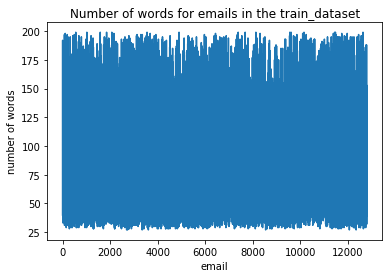

In [13]:
mail_length = []
for elem in all_x:
    mail_length.append(len(elem))
print('average email length = ', sum(mail_length) / len(mail_length))    
    
y_length = []
for elem in all_y:
    y_length.append(len(elem))
print('average y length = ', sum(y_length) / len(y_length))
    

plt.plot(mail_length)
plt.title('Number of words for emails in the train_dataset')
plt.ylabel('number of words')
plt.xlabel('email')
plt.show()

del all_x
del all_y

In [47]:
len(x), len(x_val), len(x_test)

(11520, 1280, 1280)

In [14]:
# Join list elements to a string again (because torchtext takes sentences not as lists of words but as string)

x = [' '.join(elem) for elem in x]
y = [' '.join(elem) for elem in y]

x_val = [' '.join(elem) for elem in x_val]
y_val = [' '.join(elem) for elem in y_val]

x_test = [' '.join(elem) for elem in x_test]
y_test = [' '.join(elem) for elem in y_test]

<div class="alert alert-info">

### Restart form here

In [15]:
batch_tuple = (4,4,4)

In [16]:
# Save data to csv file
# Torchtext will then pick up the csv files to build the dataset

import pandas as pd
train_df = pd.DataFrame({
    'x':x,   # labels_id
    'y': y   # fin_sentences    
})

val_df = pd.DataFrame({
    'x_val':x,   # labels_id
    'y_val': y   # fin_sentences    
})

test_df = pd.DataFrame({
    'x_test':x,   # labels_id
    'y_test': y   # fin_sentences    
})

train_df.to_csv('mail_train.tsv', sep='\t', index=False, header=False)
val_df.to_csv('mail_val.tsv', sep='\t', index=False, header=False)
test_df.to_csv('mail_test.tsv', sep='\t', index=False, header=False)

train_df_path = 'mail_train.tsv'
val_df_path = 'mail_val.tsv'
test_df_path = 'mail_test.tsv'

In [17]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [19]:
glove_embeddings_path = './glove.6B.300d.sample.txt'

In [20]:
TEXT = Field(#tokenize = tokenize_en,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

SUMMARY = Field(#tokenize = tokenize_en,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

In [21]:
# Build dataset

train, val, test = data.TabularDataset.splits(
    path='/Users/nico/UP/NLP/A_final_project', train='mail_train.tsv',
    validation='mail_val.tsv', test='mail_test.tsv', format='tsv',
    fields=[('text', TEXT), ('summary', SUMMARY)])

train_iter, val_iter, test_iter = data.BucketIterator.splits(
    (train, val, test), batch_sizes=batch_tuple,
    sort_key=lambda x: len(x.text), device=device)

TEXT.build_vocab(train, vectors=Vectors(glove_embeddings_path))
SUMMARY.build_vocab(train, vectors=Vectors(glove_embeddings_path))

vocab_text = TEXT.vocab
vocab_summary = SUMMARY.vocab

In [22]:
# print an example pair of the data

print(vars(train.examples[1]))

{'text': ['phillip', 'good', 'morning', '!', 'i', 'hope', 'you', 'had', 'a', 'wonderful', 'thanksgiving', 'with', 'your', 'family', 'and', 'safe', 'travels', '.', 'as', 'per', 'our', 'meeting', 'on', 'tuesday', ',', 'please', 'identify', 'people', 'you', 'think', 'will', 'be', 'good', 'for', 'the', 'expert', 'story', 'roles', '.', 'you', 'can', 'provide', 'me', 'a', 'list', 'and', 'either', 'contact', 'them', 'first', 'or', 'provide', 'me', 'with', 'an', 'introduction', 'to', 'get', 'their', 'commitment', '.', 'thanks', 'a', 'million', 'in', 'advance', 'for', 'your', 'continued', 'support', 'of', 'this', 'project', '.'], 'summary': ['smes', 'for', 'expert', 'stories']}


<div class="alert alert-block alert-info">
    
## Building Model architecture

    
<div>

In [23]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded)
                
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

In [24]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention= [batch size, src len]
        
        return F.softmax(attention, dim=1)


In [25]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0)

In [26]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

In [27]:
INPUT_DIM = len(TEXT.vocab) 
OUTPUT_DIM = len(SUMMARY.vocab) 
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

In [28]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(1723, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(269, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=269, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [29]:
optimizer = optim.Adam(model.parameters())


In [30]:
SUM_PAD_IDX = SUMMARY.vocab.stoi[SUMMARY.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = SUM_PAD_IDX)

In [31]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):

        src = batch.text
        trg = batch.summary
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)


In [32]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.text
            trg = batch.summary

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [33]:
def get_output_to_print_sentences(model, iterator, criterion):    
    model.eval()
        
    with torch.no_grad():
        
        output_all = []
        gold_all = []
    
        for i, batch in enumerate(iterator):

            src = batch.text
            trg = batch.summary
            
            #print(src.shape)

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]
            
            output_all.append(output)
            gold_all.append(trg)
        
    return output_all, gold_all

In [34]:
# print results and compute ROUGE and BLEU metrics for the validation data
# this cell is kind of messy but serves the purpose



def print_results(output, target, print_y_n):
    results = [ [] for i in range(batch_tuple[1]) ]
    source = [ [] for i in range(batch_tuple[1]) ]
    n = 0
    for i in range(output.shape[0]):
        
        results[n].append(vocab_summary.itos[    int(output[i].data.topk(1)[1])])
        source[n].append(vocab_summary.itos[target[i]]     )
        
        #print(vocab_summary.itos[    int(output[i].data.topk(1)[0])])


        if n == batch_tuple[1]-1:
            n = 0
        else:
            n += 1
    
    
    rouge, bleu = 0, 0
    
    remove_words = ['<eos>', '<pad>', '']
    #remove_words = []
    
    #print(results)
    
    for i in range(len(results)):
        results[i] = [word for word in results[i] if word not in remove_words]
        source[i] = [word for word in source[i] if word not in remove_words]
       

        r,b = rouge_bleu(results[i], source[i])
        if print_y_n:
            print(r,b)
        rouge += r
        bleu += b
        
        if print_y_n:
            print('generated_summary = ', ' '.join(results[i]))
            print('target_summary    = ', ' '.join(source[i]))    
            print()
            
    return rouge, bleu

def r_b_one_epoch(out, trg, yes_no):
    r,b = 0,0
    rouge, bleu = 0,0
    count = 0
    for z in range(len(out)):
        count += batch_tuple[1]
        r,b = print_results(out[z], trg[z], yes_no)
        rouge += r
        bleu += b
    print(count)
    return rouge/count, bleu/count

In [35]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [36]:
N_EPOCHS = number_of_epochs
CLIP = 1

best_valid_loss = float('inf')

perplexity_train = []
perplexity_val = []
rouge_val = []
bleu_val = []
r = 0
b = 0

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iter, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, val_iter, criterion)
    out, trg = get_output_to_print_sentences(model, val_iter, criterion)
    r,b = r_b_one_epoch(out,trg, False)
    rouge_val.append(r)
    bleu_val.append(b)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    perplexity_train.append(math.exp(train_loss))
    perplexity_val.append(math.exp(valid_loss))

128
Epoch: 01 | Time: 1m 12s
	Train Loss: 5.825 | Train PPL: 338.695
	 Val. Loss: 4.658 |  Val. PPL: 105.443
128
Epoch: 02 | Time: 0m 49s
	Train Loss: 4.650 | Train PPL: 104.619
	 Val. Loss: 4.509 |  Val. PPL:  90.854
128
Epoch: 03 | Time: 0m 53s
	Train Loss: 4.382 | Train PPL:  79.973
	 Val. Loss: 4.565 |  Val. PPL:  96.033
128
Epoch: 04 | Time: 0m 46s
	Train Loss: 4.104 | Train PPL:  60.583
	 Val. Loss: 3.873 |  Val. PPL:  48.103
128
Epoch: 05 | Time: 0m 46s
	Train Loss: 3.930 | Train PPL:  50.917
	 Val. Loss: 3.699 |  Val. PPL:  40.401
128
Epoch: 06 | Time: 0m 45s
	Train Loss: 3.681 | Train PPL:  39.674
	 Val. Loss: 3.423 |  Val. PPL:  30.647
128
Epoch: 07 | Time: 0m 45s
	Train Loss: 3.368 | Train PPL:  29.028
	 Val. Loss: 3.102 |  Val. PPL:  22.248
128
Epoch: 08 | Time: 0m 46s
	Train Loss: 3.112 | Train PPL:  22.477
	 Val. Loss: 2.899 |  Val. PPL:  18.151
128
Epoch: 09 | Time: 0m 46s
	Train Loss: 2.917 | Train PPL:  18.480
	 Val. Loss: 2.818 |  Val. PPL:  16.737
128
Epoch: 10 | Tim

In [39]:
import matplotlib.axes as ax

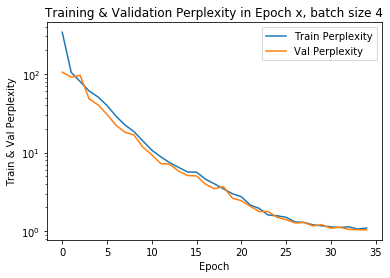

In [45]:
#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles, labels)

plt.title('Training & Validation Perplexity in Epoch x, batch size 4')
plt.ylabel('Train & Val Perplexity')
plt.xlabel('Epoch')
plt.yscale('log')
line_up, = plt.plot(perplexity_train, label='Train Perplexity')
line_down, = plt.plot(perplexity_val, label='Val Perplexity')
plt.legend(handles=[line_up, line_down])
#plt.savefig('train_val_perplexity_batch_size_4.png')

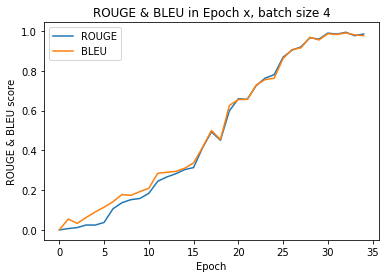

In [46]:
#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles, labels)

plt.title('ROUGE & BLEU in Epoch x, batch size 4')
plt.ylabel('ROUGE & BLEU score')
plt.xlabel('Epoch')
line_up, = plt.plot(rouge_val, label='ROUGE')
line_down, = plt.plot(bleu_val, label='BLEU')
plt.legend(handles=[line_up, line_down])
#plt.savefig('r_b_epoch_batch_size_4.png')

In [ ]:
out, trg = get_output_to_print_sentences(model, test_iter, criterion)
rouge, bleu = r_b_one_epoch(out, trg, True)

In [ ]:
# ROUGE = number_of_overlappting_words / total_words_in_reference_summary
# BLEU = number_of_overlappting_words / total_words_in_system_summary

# So, a score of 1.0 is perfect, a score of 0.0 is worst. 

# So... performance here is improvable, to say the least.

# When training for 10 epochs with 3000 emails we had ROUGE and BLEU of 7 %
# That score could be increased by:

# more training data
# better text_preprocessing (was missing the time because the data was initially processed for an other notebook)



print('average ROUGE score = ',rouge) # count
print('average BLEU score = ', bleu) # count


# 0.236
# 0.230

# batch_size = 8
# 0.86
# 0.86

# batch_size = 4
# 0.98
# 0.97

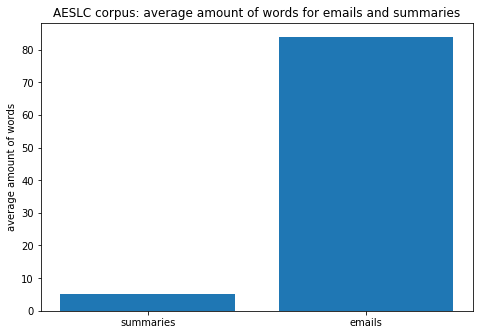

In [267]:
# length of summaries vs length of emails

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['summaries', 'emails']
plt.title('AESLC corpus: average amount of words for emails and summaries')
plt.ylabel('average amount of words')
students = [5, 84]
ax.bar(langs,students)
#plt.savefig('Average_amount_words_emails_summaries')
plt.show()

In [ ]:
average ROUGE score =  0.8646718299062048
average BLEU score =  0.8686755952380952

In [233]:
# r_4              # 0.984375
# b_4              # 0.9759114583333334

#r_8              # 0.8646718299062048
#b_8              # 0.8686755952380952

# r_16               # 0.40672348484848486
# b_16               # 0.40813802083333334

# r_32              # 0.19148065476190476
# b_32              # 0.2107204861111111



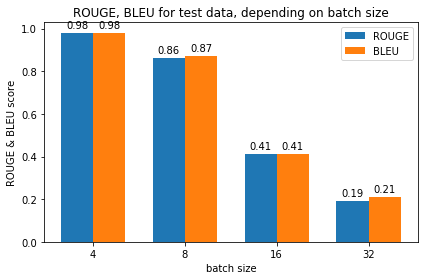

In [247]:
data = [[0.984375, 0.9759114583333334],
        [0.8646718299062048,0.8686755952380952],
        [0.40672348484848486,0.40813802083333334],
        [0.19148065476190476,0.2107204861111111]]



labels = ['4', '8', '16', '32']
rrr = [0.98, 0.86, 0.41, 0.19]
bbb = [0.98, 0.87, 0.41, 0.21]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, rrr, width, label='ROUGE')
rects2 = ax.bar(x + width/2, bbb, width, label='BLEU')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('ROUGE & BLEU score')
ax.set_xlabel('batch size')
ax.set_title('ROUGE, BLEU for test data, depending on batch size')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)



fig.tight_layout()

#plt.savefig('test_r_b_batchsz.png')
plt.show()

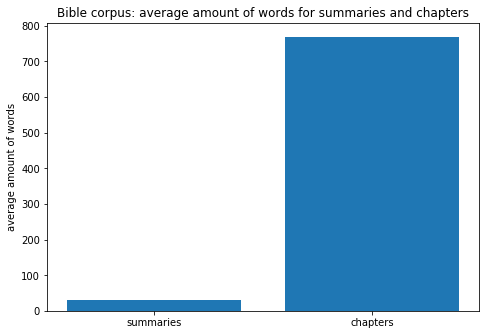

In [266]:
# length of summaries vs length of emails
# average email length =  770.1951013513514
# average y length =  29.68581081081081

"""
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

plt.title('ROUGE & BLEU in Epoch x, batch size 8')
plt.ylabel('ROUGE & BLEU score')
plt.xlabel('Epoch')
line_up, = plt.plot(rouge_val, label='ROUGE')
line_down, = plt.plot(bleu_val, label='BLEU')
#plt.savefig('blaaaa.png')
plt.legend(handles=[line_up, line_down])
"""


import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['summaries', 'chapters']
plt.title('Bible corpus: average amount of words for summaries and chapters')
plt.ylabel('average amount of words')
students = [30, 770]
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=1, hspace=1)
ax.bar(langs,students)

#plt.savefig('bible_Average_amount_words_emails_summaries')
plt.show()